# Analiza atrybutów

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [88]:
DIR_DATA = '../data/v3'

In [89]:
artists = pd.read_json(path_or_buf=f'{DIR_DATA}/artists.jsonl', lines=True)
sessions = pd.read_csv(f'{DIR_DATA}/sessions.csv')
tracks = pd.read_json(path_or_buf=f'{DIR_DATA}/tracks.jsonl', lines=True)
users = pd.read_json(path_or_buf=f'{DIR_DATA}/users.jsonl', lines=True)

### Przygotowanie danych do użycia 
- podział sesji według tygodni i utworów
- policzenie danych takich jak liczba odtworzeń, liczba polubień, przyrost odtworzeń, średni czas odtwarzania 

In [90]:
tracks = tracks.rename(columns={'id': 'track_id'})
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='coerce')
tracks['release_date'] = tracks['release_date'].dt.year

artists = artists.rename(columns={'id': 'id_artist'})

sessions_df = sessions
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['week'] = sessions_df['timestamp'].dt.strftime('%U')

start_date = pd.to_datetime('2020-12-28')

sessions_df['week'] = (sessions_df['timestamp'] - start_date).dt.days // 7
sessions_df['week'] = sessions_df['week'] + 1

sessions_df = sessions_df[sessions_df.week.isin([1, 158]) == False]

merged_df = pd.merge(tracks[['track_id','duration_ms']], sessions_df, on='track_id', how='inner')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4969300 entries, 0 to 4969299
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   track_id     object        
 1   duration_ms  int64         
 2   session_id   int64         
 3   timestamp    datetime64[ns]
 4   user_id      int64         
 5   event_type   object        
 6   week         int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 303.3+ MB


Liczenie sumy wartości odtworzeń i polubień utworu w danym tygodniu

In [91]:
all_weeks = sorted(sessions_df['week'].unique())
all_tracks = tracks['track_id'].unique()


df1 = pd.DataFrame({'track_id': all_tracks[:]})
df2 = pd.DataFrame({'week': all_weeks[:]})

empty_track_week_df = pd.merge(df1, df2, how='cross')

counts_df = sessions_df.groupby(['week', 'track_id'])['event_type'].value_counts().unstack(fill_value=0)
counts_df = counts_df.rename(columns={'play': 'play_count', 'like': 'like_count', 'skip': 'skip_count'}).reset_index()

tw_counts_df = pd.merge(empty_track_week_df, counts_df, on=['week', 'track_id'], how='left')
tw_counts_df = tw_counts_df.fillna(0)

del df1
del df2
del counts_df
del sessions_df
gc.collect()

print(tw_counts_df.tail)
tw_counts_df.info()


<bound method NDFrame.tail of                        track_id  week  like_count  play_count  skip_count
0        0RNxWy0PC3AyH4ThH3aGK6     2         0.0         0.0         0.0
1        0RNxWy0PC3AyH4ThH3aGK6     3         0.0         0.0         0.0
2        0RNxWy0PC3AyH4ThH3aGK6     4         0.0         0.0         0.0
3        0RNxWy0PC3AyH4ThH3aGK6     5         0.0         0.0         0.0
4        0RNxWy0PC3AyH4ThH3aGK6     6         0.0         0.0         0.0
...                         ...   ...         ...         ...         ...
3496267  27Y1N4Q4U3EfDU5Ubw8ws2   153         1.0         1.0         0.0
3496268  27Y1N4Q4U3EfDU5Ubw8ws2   154         0.0         0.0         0.0
3496269  27Y1N4Q4U3EfDU5Ubw8ws2   155         0.0         1.0         1.0
3496270  27Y1N4Q4U3EfDU5Ubw8ws2   156         1.0         1.0         0.0
3496271  27Y1N4Q4U3EfDU5Ubw8ws2   157         1.0         1.0         0.0

[3496272 rows x 5 columns]>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349

In [92]:
playtime_df = merged_df.copy()
playtime_df = playtime_df[playtime_df["event_type"] != "like"].copy()


grouped_df = playtime_df.groupby(['week', 'track_id', 'user_id'])
playtime_df['next_timestamp'] = grouped_df['timestamp'].shift(-1)
playtime_df['next_event_type'] = grouped_df['event_type'].shift(-1)


play_mask = (playtime_df['event_type'] == 'play') & (playtime_df['next_event_type'] == 'skip')
play_duration = (playtime_df['next_timestamp'] - playtime_df['timestamp']).dt.total_seconds() * 1000
track_duration = playtime_df['duration_ms']

playtime_df['playtime_ratio'] = 1
playtime_df.loc[play_mask, 'playtime_ratio'] = play_duration[play_mask] / track_duration[play_mask]


playtime_df = playtime_df.drop(['next_event_type', 'next_timestamp'], axis=1)
playtime_df = playtime_df[playtime_df["event_type"] != "skip"].reset_index()


grouped_playtime = playtime_df[playtime_df['event_type'] == 'play'].groupby(['track_id', 'week'])
mean_playtime = grouped_playtime['playtime_ratio'].mean().reset_index()

del play_mask
del play_duration
del track_duration
del grouped_df
del grouped_playtime
del playtime_df
gc.collect()

mean_playtime.info()
print(mean_playtime[mean_playtime["track_id"] == "27Y1N4Q4U3EfDU5Ubw8ws2"].sort_values(by="week"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160061 entries, 0 to 1160060
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   track_id        1160061 non-null  object 
 1   week            1160061 non-null  int64  
 2   playtime_ratio  1160061 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 26.6+ MB
                      track_id  week  playtime_ratio
327980  27Y1N4Q4U3EfDU5Ubw8ws2     2        1.000000
327981  27Y1N4Q4U3EfDU5Ubw8ws2     3        1.000000
327982  27Y1N4Q4U3EfDU5Ubw8ws2     5        0.882955
327983  27Y1N4Q4U3EfDU5Ubw8ws2     6        1.000000
327984  27Y1N4Q4U3EfDU5Ubw8ws2     8        1.000000
...                        ...   ...             ...
328062  27Y1N4Q4U3EfDU5Ubw8ws2   152        0.989200
328063  27Y1N4Q4U3EfDU5Ubw8ws2   153        1.000000
328064  27Y1N4Q4U3EfDU5Ubw8ws2   155        0.369033
328065  27Y1N4Q4U3EfDU5Ubw8ws2   156        1.000000
328066 

In [93]:
all_counts_df = pd.merge(tw_counts_df, mean_playtime, on=['week', 'track_id'], how='left')
all_counts_df = all_counts_df.fillna(0)

all_counts_df['lag_skip_count'] = all_counts_df.groupby('track_id')['skip_count'].shift(1)
all_counts_df['lag_like_count'] = all_counts_df.groupby('track_id')['like_count'].shift(1)
all_counts_df['lag_playtime_ratio'] = all_counts_df.groupby('track_id')['playtime_ratio'].shift(1)
all_counts_df['lag_1'] = all_counts_df.groupby('track_id')['play_count'].shift(1)
all_counts_df['lag_2'] = all_counts_df.groupby('track_id')['play_count'].shift(2)
all_counts_df['lag_3'] = all_counts_df.groupby('track_id')['play_count'].shift(3)
all_counts_df['lag_4'] = all_counts_df.groupby('track_id')['play_count'].shift(3)
all_counts_df['lag_5'] = all_counts_df.groupby('track_id')['play_count'].shift(3)

 
track_features = ['track_id', 'popularity', 'duration_ms', 'explicit', 'danceability', 
            'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'release_date', 'id_artist']


df_track_artist = tracks[track_features].copy()

le = LabelEncoder()
df_track_artist['id_artist'] = le.fit_transform(df_track_artist['id_artist'])


full_df = pd.merge(all_counts_df, df_track_artist, on=['track_id'], how='left')
full_df = full_df.fillna(0)


del df_track_artist
del all_counts_df
gc.collect()

full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3496272 entries, 0 to 3496271
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   track_id            object 
 1   week                int64  
 2   like_count          float64
 3   play_count          float64
 4   skip_count          float64
 5   playtime_ratio      float64
 6   lag_skip_count      float64
 7   lag_like_count      float64
 8   lag_playtime_ratio  float64
 9   lag_1               float64
 10  lag_2               float64
 11  lag_3               float64
 12  lag_4               float64
 13  lag_5               float64
 14  popularity          int64  
 15  duration_ms         int64  
 16  explicit            int64  
 17  danceability        float64
 18  energy              float64
 19  key                 int64  
 20  loudness            float64
 21  speechiness         float64
 22  acousticness        float64
 23  instrumentalness    float64
 24  liveness            floa

,track_id,week,like_count,play_count,skip_count,playtime_ratio,lag_skip_count,lag_like_count,lag_playtime_ratio,lag_1,...,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_date,id_artist
0,0RNxWy0PC3AyH4ThH3aGK6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-14.141,0.0697,0.586,0.0,0.332,0.713,88.973,1929,200
1,0RNxWy0PC3AyH4ThH3aGK6,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-14.141,0.0697,0.586,0.0,0.332,0.713,88.973,1929,200
2,0RNxWy0PC3AyH4ThH3aGK6,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-14.141,0.0697,0.586,0.0,0.332,0.713,88.973,1929,200
3,0RNxWy0PC3AyH4ThH3aGK6,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-14.141,0.0697,0.586,0.0,0.332,0.713,88.973,1929,200
4,0RNxWy0PC3AyH4ThH3aGK6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-14.141,0.0697,0.586,0.0,0.332,0.713,88.973,1929,200


## Macierze korelacji

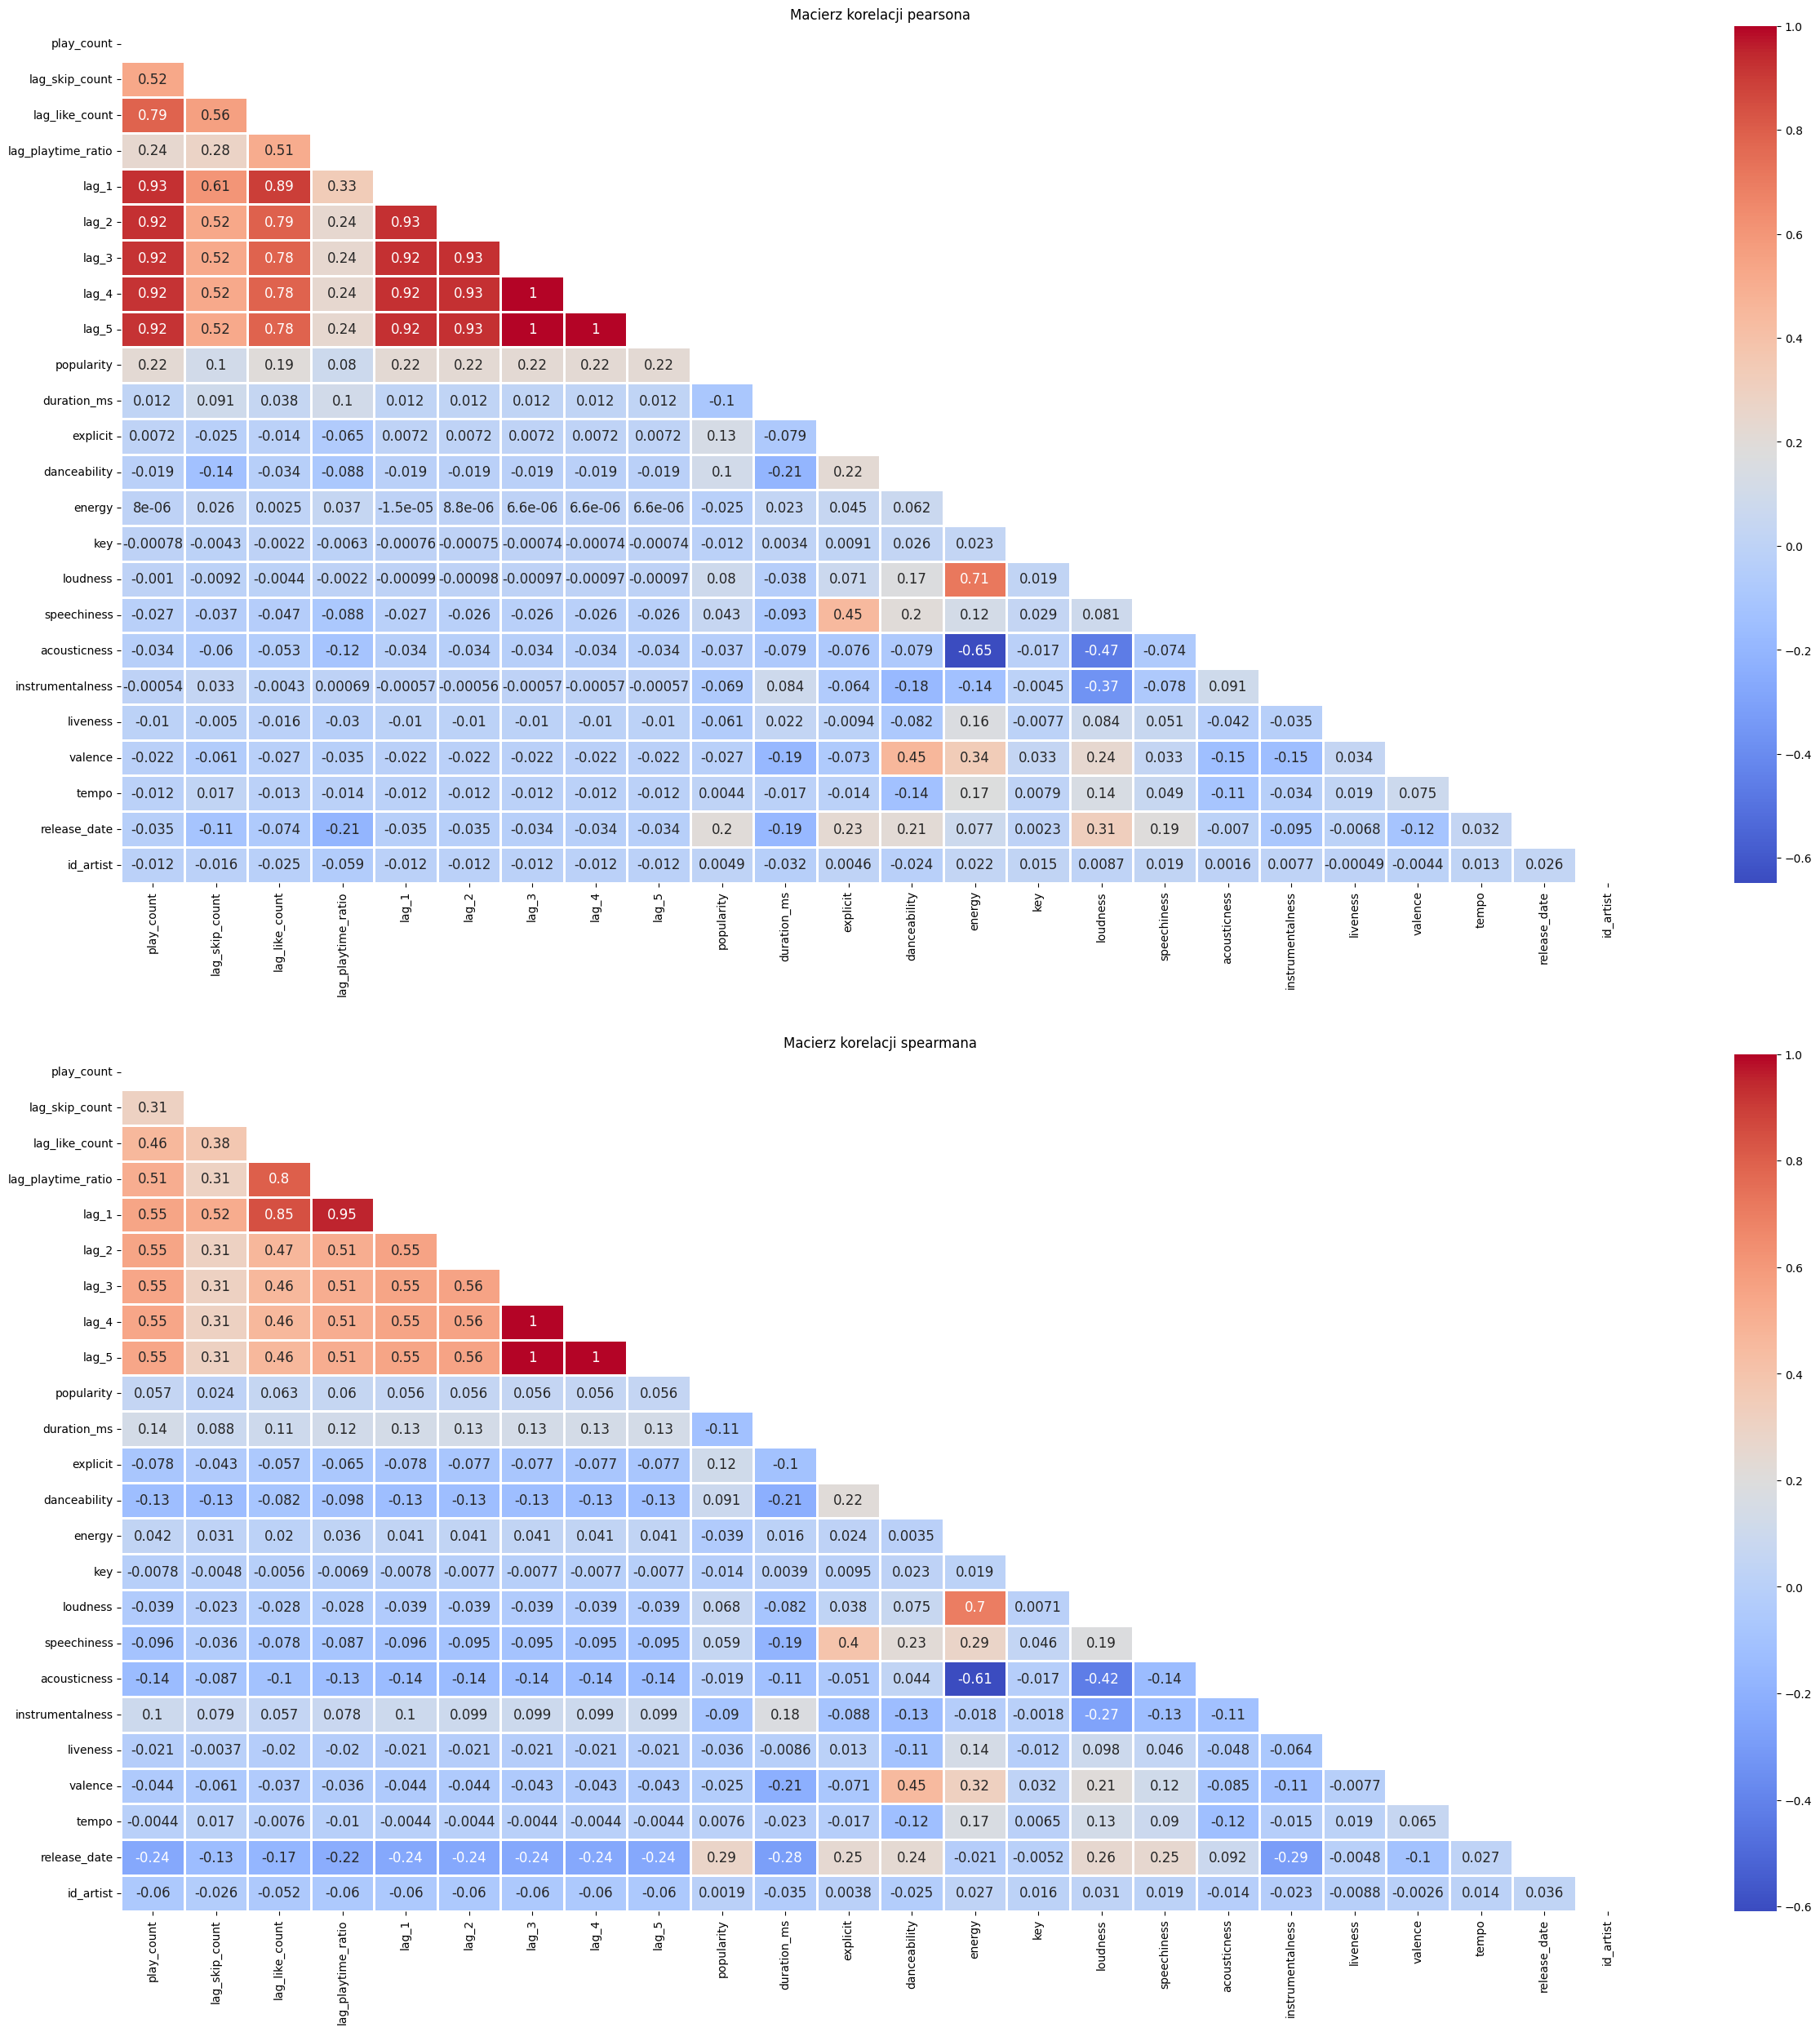

Macierz korelacji pearsona
play_count            1.000000
lag_skip_count        0.523795
lag_like_count        0.787503
lag_playtime_ratio    0.237354
lag_1                 0.926956
lag_2                 0.923399
lag_3                 0.920365
lag_4                 0.920365
lag_5                 0.920365
popularity            0.220147
Name: play_count, dtype: float64
Macierz korelacji spearmana
play_count            1.000000
lag_skip_count        0.312389
lag_like_count        0.464488
lag_playtime_ratio    0.511794
lag_1                 0.553601
lag_2                 0.550798
lag_3                 0.547462
lag_4                 0.547462
lag_5                 0.547462
popularity            0.056514
duration_ms           0.135346
explicit             -0.077901
danceability         -0.127467
speechiness          -0.096417
acousticness         -0.140212
instrumentalness      0.100526
release_date         -0.241860
id_artist            -0.060413
Name: play_count, dtype: float64


In [94]:
full_df = full_df.drop(['like_count', 'playtime_ratio', 'skip_count'], axis=1)
fig, axes = plt.subplots(2, 1, figsize=(30, 30))

correlation_matrix1 = full_df.drop(['track_id', 'week'], axis=1).corr('pearson')

ax = sns.heatmap(
    correlation_matrix1,
    annot=True,
    annot_kws={"fontsize": 12},
    mask=np.triu(correlation_matrix1),
    linewidths=2,
    cmap="coolwarm",
    ax=axes[0]
)
axes[0].set_title('Macierz korelacji pearsona')


correlation_matrix2 = full_df.drop(['track_id', 'week'], axis=1).corr('spearman')

ax = sns.heatmap(
    correlation_matrix2,
    annot=True,
    annot_kws={"fontsize": 12},
    mask=np.triu(correlation_matrix2),
    linewidths=2,
    cmap="coolwarm",
    ax=axes[1]
)
axes[1].set_title('Macierz korelacji spearmana')

plt.show()

print('Macierz korelacji pearsona')
print(correlation_matrix1[abs(correlation_matrix1['play_count']) > 0.05]['play_count']) 

print('Macierz korelacji spearmana')
print(correlation_matrix2[abs(correlation_matrix2['play_count']) > 0.05]['play_count']) 


Eksport preprocesowanego zestawu danych  

In [95]:
feature_set = ['track_id', 'week', 'lag_like_count', 'lag_skip_count', 'lag_playtime_ratio', 
               'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'popularity', 'release_date',
               'duration_ms', 'danceability', 'acousticness', 'instrumentalness', 
               'play_count']
print(feature_set)

final_df = full_df[feature_set].copy()

final_df.info()
final_df.to_csv('preprocessed_data.csv', index=False)

# del full_df
# gc.collect()

['track_id', 'week', 'lag_like_count', 'lag_skip_count', 'lag_playtime_ratio', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'popularity', 'release_date', 'duration_ms', 'danceability', 'acousticness', 'instrumentalness', 'play_count']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3496272 entries, 0 to 3496271
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   track_id            object 
 1   week                int64  
 2   lag_like_count      float64
 3   lag_skip_count      float64
 4   lag_playtime_ratio  float64
 5   lag_1               float64
 6   lag_2               float64
 7   lag_3               float64
 8   lag_4               float64
 9   lag_5               float64
 10  popularity          int64  
 11  release_date        int64  
 12  duration_ms         int64  
 13  danceability        float64
 14  acousticness        float64
 15  instrumentalness    float64
 16  play_count          float64
dtypes: float64(12), int6

In [96]:
read_data = pd.read_csv(f'preprocessed_data.csv')
read_data.info()
read_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496272 entries, 0 to 3496271
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   track_id            object 
 1   week                int64  
 2   lag_like_count      float64
 3   lag_skip_count      float64
 4   lag_playtime_ratio  float64
 5   lag_1               float64
 6   lag_2               float64
 7   lag_3               float64
 8   lag_4               float64
 9   lag_5               float64
 10  popularity          int64  
 11  release_date        int64  
 12  duration_ms         int64  
 13  danceability        float64
 14  acousticness        float64
 15  instrumentalness    float64
 16  play_count          float64
dtypes: float64(12), int64(4), object(1)
memory usage: 453.5+ MB


,track_id,week,lag_like_count,lag_skip_count,lag_playtime_ratio,lag_1,lag_2,lag_3,lag_4,lag_5,popularity,release_date,duration_ms,danceability,acousticness,instrumentalness,play_count
0,0RNxWy0PC3AyH4ThH3aGK6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1929,201467,0.673,0.586,0.0,0.0
1,0RNxWy0PC3AyH4ThH3aGK6,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1929,201467,0.673,0.586,0.0,0.0
2,0RNxWy0PC3AyH4ThH3aGK6,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1929,201467,0.673,0.586,0.0,0.0
3,0RNxWy0PC3AyH4ThH3aGK6,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1929,201467,0.673,0.586,0.0,0.0
4,0RNxWy0PC3AyH4ThH3aGK6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1929,201467,0.673,0.586,0.0,0.0


## Prosty model regresji dla przewidywania słuchalności każdego z utworów

In [132]:
features = ['lag_like_count', 'lag_skip_count', 'lag_playtime_ratio', 
               'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'popularity', 'release_date',
               'duration_ms', 'danceability', 'acousticness', 'instrumentalness']
target = ['play_count']

unique_tracks = sessions['track_id'].unique()
dataset = final_df[final_df['track_id'].isin(unique_tracks)].copy()

train_x = final_df[final_df['week'] <= 100][features]
train_y = final_df[final_df['week'] <= 100][target]
test_x = final_df[final_df['week'] > 127][features]
test_y = final_df[final_df['week'] > 127][['track_id', 'play_count']] # take 10 weeks


In [133]:
# Jeden model dla wszystkich piosenek

model = LinearRegression()
model.fit(train_x, train_y)

# Make predictions on the test set
test_y['predicted'] = model.predict(test_x)

# Calculate the Mean Squared Error on the test set
mse_test = mean_squared_error(test_y['play_count'], test_y['predicted'])
print(f"Mean Squared Error on Test Set: {mse_test}")

ndcgs = []
# Lista top20 utworów w kolejnych tygodniach
for week in range(0, 30):
    test_week = test_y.iloc[week::30].copy()

    ground_truth = test_week.sort_values(by='predicted', ascending=False)['play_count'].values.reshape(1, -1)
    predicted = test_week.sort_values(by='predicted', ascending=False)['predicted'].values.reshape(1, -1)
    # ground_truth = test_week['actual_rank'].values.reshape(1, -1)
    # predicted = np.arange(1, 12304).reshape(1, -1)
    
    print(ground_truth)
    print(predicted)
    ndcgs.append(ndcg_score(ground_truth, predicted, k=100))

print(ndcgs)
print(np.mean(ndcgs))

Mean Squared Error on Test Set: 1.136844439915792
[[47. 39. 58. ...  0.  0.  2.]]
[[ 6.18961705e+01  6.14171360e+01  6.13988791e+01 ... -4.86670203e-02
  -5.22663438e-02 -6.68018073e-02]]
[[59. 61. 55. ...  0.  0.  0.]]
[[ 6.38244807e+01  6.35622726e+01  6.28739260e+01 ... -4.86670203e-02
  -5.22663438e-02 -9.95644719e-02]]
[[56. 57. 55. ...  0.  0.  0.]]
[[ 6.70613632e+01  6.27942594e+01  6.10004333e+01 ... -4.65361792e-02
  -4.86670203e-02 -5.22663438e-02]]
[[41. 62. 47. ...  0.  1.  0.]]
[[ 6.69537080e+01  6.66741628e+01  6.28517900e+01 ... -5.55217549e-02
  -6.63972155e-02 -7.40183395e-02]]
[[49. 44. 46. ...  0.  0.  0.]]
[[ 6.38488461e+01  5.95066553e+01  5.86281463e+01 ... -4.86670203e-02
  -5.22663438e-02 -9.45500941e-02]]
[[49. 65. 45. ...  0.  0.  0.]]
[[ 6.03172918e+01  5.80333593e+01  5.74094706e+01 ... -4.65361792e-02
  -4.86670203e-02 -5.22663438e-02]]
[[39. 49. 49. ...  0.  0.  0.]]
[[ 6.02837682e+01  5.90444556e+01  5.80856623e+01 ... -4.86670203e-02
  -4.90358891e-02 -5

Dla danych całych:
Wyliczone NDCG w prostym modelu: 0.9536635333617488  
Wyliczone MSE w prostym modelu: 1.195824191051509

Tylko dla istotnych piosenek:
Wyliczone NDCG w prostym modelu: 0.9536635333617488  
Wyliczone MSE w prostym modelu: 2.046390082388259